# Monte Carlo Simulation of the Nonparametric and Semiparametric Estimators

In [1]:
# load general packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import numba as nb

# Import user package
import functions as funcs

## Uncomment for nicer plots ##
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rc('axes', axisbelow=True)

In [2]:
# Set seed once
np.seed = 200

In [4]:
# Set Monte Carlo parameters
reps = 10_000 # Repetitions
n = 50_000 # Size of each sample

For $\alpha = 1.5$

In [5]:
# Set distribution parameters
alpha_1 = 1.5
mu = 0.0

# Initialize
G_vec_1 = np.zeros(shape=reps)
G_nonparam_vec_1 = np.zeros(shape=reps)

# Loop over replications for now
for rep in range(reps):
    
    # Draw values
    rand = np.random.uniform(0,1, size=n)
    x = mu - 1 + (1 - rand)**(-1/alpha_1)
    
    # Compute p
    P = 0.01
    u = np.percentile(x,100*(1-P))

    # Estmate alpha
    N_1 = np.size(x[x>=u])    
    alpha_hat = N_1 / (np.sum(np.log(x[x>u])) - N_1*np.log(u))
    
    # Compute S
    x_low = x[x<u] # Is this needed?
    E_low = np.mean(x[x<u])
    S = alpha_hat/(alpha_hat-1)*u*P / (alpha_hat/(alpha_hat-1)*u*P + E_low * (1-P))
    S_alvaredo = np.mean(x[x>=u]) / (np.mean(x[x>=u]) + E_low) # Numerical top income share

    # Compute the Gini coefficients with both methods
    G_high = 1/(2*alpha_hat-1)
    G_low = funcs.gini(x[x<u])
    
    G = G_high*P*S + G_low*(1-P)*(1-S) + S - P
    G_nonparam = funcs.gini(x)
    
    # Save values
    G_vec_1[rep] = G
    G_nonparam_vec_1[rep] = G_nonparam

Plot the results

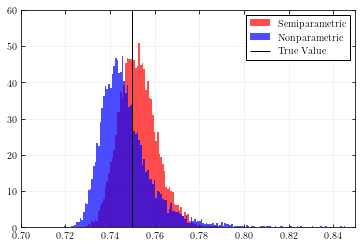

In [16]:
# Compute the true gini
eta_1 = mu-1 + alpha_1/(alpha_1-1)
G_true_1 = 1 - 2/eta_1 * ( (mu-1)/2 + alpha_1/(alpha_1-1)*(1 - alpha_1/(2*alpha_1-1)))

# Plot
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9', zorder=0)
ax.tick_params(axis='both', bottom=True, top=True, left=True, right=True, direction='in', which='both')

ax.hist(G_vec_1, density = True, bins = np.linspace(.7,.85,200), color = 'red', alpha = 0.7, zorder = 2, label='Semiparametric', histtype='stepfilled')
ax.hist(G_nonparam_vec_1, density = True, bins = np.linspace(.7,.85,200), color = 'blue', alpha = 0.7, zorder = 2, label='Nonparametric', histtype='stepfilled')

ax.vlines(G_true_1, ymin=0,ymax=100, linestyle = '-', linewidth = 1.0, label='True Value', zorder=3)
ax.set_ylim(0,60)
ax.set_xlim(0.7,.85)

ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/estimator_15.pdf')

Compute kernel density

In [49]:
# First compute the mode using kernel density
kd_nonparam_1 = stats.gaussian_kde(G_nonparam_vec_1)
kd_semiparam_1 = stats.gaussian_kde(G_vec_1)

# Define point on which to evaluate the estimated pdf's
points_1 = np.linspace(.71,.85,200)
kd_11 = kd_nonparam_1.pdf(points)
kd_12 = kd_semiparam_1.pdf(points)

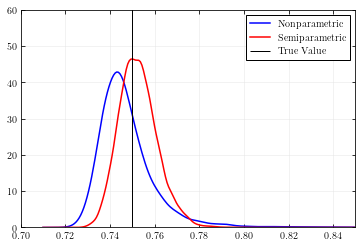

In [67]:
# Plot results
# Plot
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9', zorder=0)
ax.tick_params(axis='both', bottom=True, top=True, left=True, right=True, direction='in', which='both')

ax.plot(points_1, kd_11, color = 'blue', linestyle ='-', zorder = 2, linewidth=1.5, label = 'Nonparametric')
ax.plot(points_1, kd_12, color = 'red', linestyle = '-', zorder = 2, linewidth = 1.5, label = 'Semiparametric')

ax.vlines(G_true_1, ymin=0,ymax=100, linestyle = '-', linewidth = 1.0, label='True Value', zorder=3)
ax.set_ylim(0,60)
ax.set_xlim(0.7,.85)

ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/kd_1.pdf')

In [68]:
# Compute mode
mode_nonparam_1 = points_1[np.argmax(kd_11)]
mode_semiparam_1 = points_1[np.argmax(kd_12)]

0.7430653266331658

Compute summary statistics

In [54]:
print('Nonparam bias = ' + str(np.mean(G_nonparam_vec_1) - G_true_1))
print('Semiparam bias = ' + str(np.mean(G_vec_1) - G_true_1))

print('Nonparam bias (mode) = ' + str(mode_nonparam_1 - G_true_1))
print('Semiparam bias (mode) = ' + str(mode_semiparam_1 - G_true_1))

print('Nonparam variance = ' + str(np.std(G_nonparam_vec_1)))
print('Semiparam variance = ' + str(np.std(G_vec_1)))

print('Nonparam skewness = ' + str(stats.skew(G_nonparam_vec_1)))
print('Semiparam skewness = ' + str(stats.skew(G_vec_1)))

Nonparam bias = -0.0018597624801071078
Semiparam bias = 0.002628326715806817
Nonparam bias (mode) = -0.0069346733668341765
Semiparam bias (mode) = 0.00010050251256277232
Nonparam variance = 0.01533912639731005
Semiparam variance = 0.008577228784523399
Nonparam skewness = 3.920432265624547
Semiparam skewness = 0.468590213803735


**See if I can compute the mode somehow**

For $\alpha = 1.2$

In [69]:
# Set distribution parameters
alpha_2 = 1.2
mu = 0.0

# Initialize
G_vec_2 = np.zeros(shape=reps)
G_nonparam_vec_2 = np.zeros(shape=reps)

# Loop over replications for now
for rep in range(reps):
    
    # Draw values
    rand = np.random.uniform(0,1, size=n)
    x = mu - 1 + (1 - rand)**(-1/alpha_2)
    
    # Compute p
    P = 0.01
    u = np.percentile(x,100*(1-P))

    # Estmate alpha
    N_1 = np.size(x[x>=u])    
    alpha_hat = N_1 / (np.sum(np.log(x[x>u])) - N_1*np.log(u))
    
    # Compute S
    x_low = x[x<u] # Is this needed?
    E_low = np.mean(x[x<u])
    S = alpha_hat/(alpha_hat-1)*u*P / (alpha_hat/(alpha_hat-1)*u*P + E_low * (1-P))
    S_alvaredo = np.mean(x[x>=u]) / (np.mean(x[x>=u]) + E_low) # Numerical top income share

    # Compute the Gini coefficients with both methods
    G_high = 1/(2*alpha_hat-1)
    G_low = funcs.gini(x[x<u])
    
    G = G_high*P*S + G_low*(1-P)*(1-S) + S - P
    G_nonparam = funcs.gini(x)
    
    # Save values
    G_vec_2[rep] = G
    G_nonparam_vec_2[rep] = G_nonparam

Plot the results

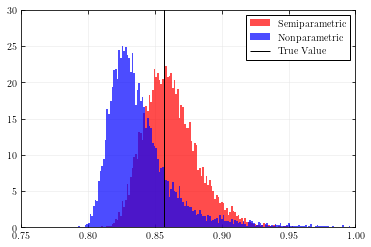

In [70]:
# Compute the true gini
eta_2 = mu-1 + alpha_2/(alpha_2-1)
G_true_2 = 1 - 2/eta_2 * ( (mu-1)/2 + alpha_2/(alpha_2-1)*(1 - alpha_2/(2*alpha_2-1)))

# Plot
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9', zorder=0)
ax.tick_params(axis='both', bottom=True, top=True, left=True, right=True, direction='in', which='both')

ax.hist(G_vec_2, density = True, bins = np.linspace(.75,1,200), color = 'red', alpha = 0.7, zorder = 2, label='Semiparametric', histtype='stepfilled')
ax.hist(G_nonparam_vec_2, density = True, bins =  np.linspace(.75,1,200), color = 'blue', alpha = 0.7, zorder = 2, label='Nonparametric', histtype='stepfilled')

ax.vlines(G_true_2, ymin=0,ymax=100, linestyle = '-', linewidth = 1.0, label='True Value', zorder=3)
ax.set_ylim(0,30)
ax.set_xlim(0.75,1)

ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/estimator_12.pdf')

In [76]:
# First compute the mode using kernel density
kd_nonparam_2 = stats.gaussian_kde(G_nonparam_vec_2)
kd_semiparam_2 = stats.gaussian_kde(G_vec_2)

# Define point on which to evaluate the estimated pdf's
points_2 = np.linspace(.75,1,200)
kd_21 = kd_nonparam_2.pdf(points_2)
kd_22 = kd_semiparam_2.pdf(points_2)

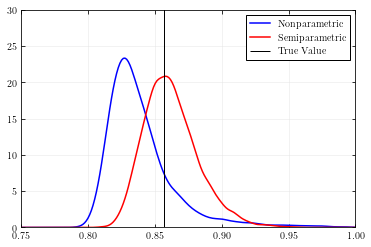

In [80]:
# Plot results
# Plot
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9', zorder=0)
ax.tick_params(axis='both', bottom=True, top=True, left=True, right=True, direction='in', which='both')

ax.plot(points_2, kd_21, color = 'blue', linestyle ='-', zorder = 2, linewidth=1.5, label = 'Nonparametric')
ax.plot(points_2, kd_22, color = 'red', linestyle = '-', zorder = 2, linewidth = 1.5, label = 'Semiparametric')

ax.vlines(G_true_2, ymin=0,ymax=100, linestyle = '-', linewidth = 1.0, label='True Value', zorder=3)
ax.set_ylim(0,30)
ax.set_xlim(0.75,1)

ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/kd_2.pdf')

In [78]:
# Compute mode
mode_nonparam_2 = points_2[np.argmax(kd_21)]
mode_semiparam_2 = points_2[np.argmax(kd_22)]

In [79]:
print('Nonparam bias = ' + str(np.mean(G_nonparam_vec_2) - G_true_2))
print('Semiparam bias = ' + str(np.mean(G_vec_2) - G_true_2))

print('Nonparam bias (mode) = ' + str(mode_nonparam_2 - G_true_2))
print('Semiparam bias (mode) = ' + str(mode_semiparam_2 - G_true_2))

print('Nonparam variance = ' + str(np.std(G_nonparam_vec_2)))
print('Semiparam variance = ' + str(np.std(G_vec_2)))

print('Nonparam skewness = ' + str(stats.skew(G_nonparam_vec_2)))
print('Semiparam skewness = ' + str(stats.skew(G_vec_2)))

Nonparam bias = -0.017410439265306055
Semiparam bias = 0.005315192861668483
Nonparam bias (mode) = -0.029253409906676464
Semiparam bias (mode) = 0.0008973438621677765
Nonparam variance = 0.026030803086283336
Semiparam variance = 0.020248307353577407
Nonparam skewness = 2.0481043843392492
Semiparam skewness = 0.7135023025704469
